In [28]:
import os
import sys
import re
import time
import yaml
import shutil
import argparse
import tarfile
import tempfile
import random
import subprocess
import copy

import numpy as np
import pandas as pd

import torch

import boda
from boda.common import utils
from boda.common.utils import set_best, save_model, unpack_artifact, model_fn

import hypertune

import matplotlib.pyplot as plt
import seaborn as sns


In [29]:
# K562 seqs, clamped
seq_fn = './test_seqs/sg__k562__sa__track_000_round_5__20211207_004203__632367.pt'
# HepG2 seqs, clamped energies
seq_fn = './sg__hepg2__sa__track_001_round_5__20211207_063610__124703.pt'
seq_fn = '/test__20211214_053743__171287.pt'
seq_fn = 'gs://syrgoth/boda_library_design_202112/extra_pickles_3/sg__hepg2__sa_rep__track_001__round_0__20211214_100033__420816.pt'

In [30]:
if 'gs://' == seq_fn[:5]:
    with tempfile.TemporaryDirectory() as tempdir:
        temp_loc = os.path.join(tempdir, os.path.basename(seq_fn))
        subprocess.check_call(['gsutil','cp',seq_fn, temp_loc])
        load_seqs = torch.load(temp_loc)
else:
    load_seqs = torch.load(seq_fn)
load_seqs.keys()

dict_keys(['proposals', 'args', 'timestamp', 'random_tag'])

In [31]:
proposal_sets = load_seqs['proposals']
args          = load_seqs['args']
timestamp     = load_seqs['timestamp']
random_tag    = load_seqs['random_tag']

In [32]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')

unpack_artifact(args['Energy Module args'].model_artifact)

model_dir = './artifacts'

my_model = model_fn(model_dir)
my_model.cuda()

Loaded model from 20211113_021200 in eval mode


archive unpacked in ./


BassetBranched(
  (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
    (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
  (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): LinearNorm(
    (linear): Linear(in

In [33]:
left_flank = boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_UPSTREAM[-200:] 
).unsqueeze(0)
print(f'Left flanking sequence shape: {left_flank.shape}')

right_flank= boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_DOWNSTREAM[:200] 
).unsqueeze(0)
print(f'Right flanking sequence shape: {right_flank.shape}')

def add_flanks(data, left_flank=left_flank, right_flank=right_flank):
    bsz, n_chan, insert_len = data.shape
    left_flank = left_flank.to(data.device).expand(bsz,-1,-1)
    right_flank= right_flank.to(data.device).expand(bsz,-1,-1)
    return torch.cat([left_flank, data, right_flank], dim=-1)
    

Left flanking sequence shape: torch.Size([1, 4, 200])
Right flanking sequence shape: torch.Size([1, 4, 200])


In [34]:
proposal_sets[0]['proposals']

tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 1.]],

        [[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 1., 0.]],

        [[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 1., 0.],
         [1., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        ...,

        [[0., 0., 0.,  ..., 1., 1., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 1., 0., 1.]],

        [[0., 0., 0.,  ..., 1., 1., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0

In [35]:
utils.batch2fasta(proposal_sets[0]['proposals'], '/'+os.path.basename(seq_fn.replace('.pt','.fa')))

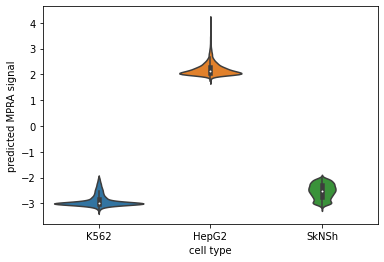

In [36]:
for i in range(len(proposal_sets)):
    with torch.no_grad():
        preds = my_model(add_flanks(proposal_sets[i]['proposals']).cuda())
        preds = pd.DataFrame(
            {'predicted MPRA signal': preds.flatten().cpu().numpy(),
             'cell type': ['K562','HepG2','SkNSh'] * preds.shape[0]}
        )
    sns.violinplot(data=preds, x='cell type', y='predicted MPRA signal')
    plt.show()

In [12]:
pen_round = 3

In [13]:
print(proposal_sets[pen_round]['penalty']['streme_output']['output'].decode('utf-8'))

********************************************************************************
STREME - Sensitive, Thorough, Rapid, Enriched Motif Elicitation
********************************************************************************
MEME version 5.4.0 (Release date: Sat Aug 21 19:23:23 2021 -0700)

For further information on how to interpret these results please access https://meme-suite.org/meme.
To get a copy of the MEME Suite software please access https://meme-suite.org.

********************************************************************************


********************************************************************************
REFERENCE
********************************************************************************
If you use this program in your research, please cite:

Timothy L. Bailey,
"STREME: accurate and versatile sequence motif discovery",
Bioinformatics, Mar. 24, 2021.
********************************************************************************


ALPHABET= ACGT

strands

In [14]:
from boda.common import constants
from boda.common.utils import align_to_alphabet
from boda.generator.plot_tools import ppm_to_IC, matrix_to_dms
from boda.common.pymeme import parse_streme_output

def ppm_to_pcm(in_tensor, bkg=[0.25,0.25,0.25,0.25], contour_base=1.5):
    argument = in_tensor.div(torch.tensor(bkg).unsqueeze(1))
    motif = torch.log2(argument) #* contour_base ** torch.maximum(argument-1.9, torch.zeros_like(argument))
    return motif

def reverse_complement(in_tensor, alphabet=constants.STANDARD_NT):
    rc_dict = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
    reversed_alphabet = [rc_dict[nt] for nt in alphabet]
    out_tensor = align_to_alphabet(in_tensor, in_order=alphabet,  out_order=reversed_alphabet)
    out_tensor = torch.flip(out_tensor, dims=[1])
    return out_tensor

def show_streme_motifs(parsed_output, plot_type=ppm_to_IC):
    motif_dict = parsed_output['motif_results']
    results_alphabet = parsed_output['meta_data']['alphabet']
    for motif_idx in range(len(motif_dict)):
        motif_ppm = torch.tensor((motif_dict[motif_idx]['ppm']))
        motif_ppm_rc = reverse_complement(motif_ppm)
        print(motif_dict[motif_idx]['summary'])
        matrix_to_dms(plot_type(motif_ppm), y_max=3)
        plt.show()
        matrix_to_dms(plot_type(motif_ppm_rc), y_max=3)
        plt.show()

{'alength': 4, 'w': 15, 'nsites': 957, 'E': 1.2e-44}


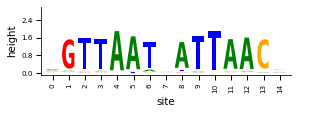

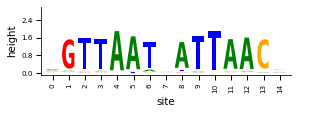

{'alength': 4, 'w': 9, 'nsites': 34, 'E': 0.15}


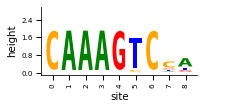

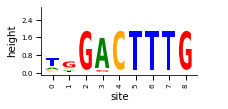

{'alength': 4, 'w': 11, 'nsites': 55, 'E': 0.92}


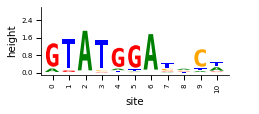

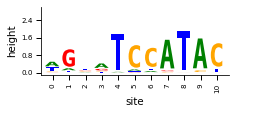

{'alength': 4, 'w': 9, 'nsites': 60, 'E': 1.6}


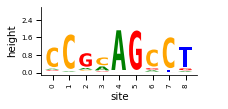

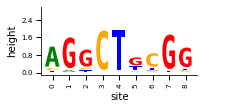

{'alength': 4, 'w': 14, 'nsites': 27, 'E': 2.5}


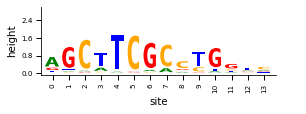

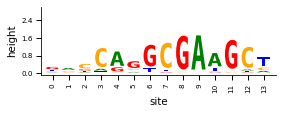

In [15]:
show_streme_motifs(
    parse_streme_output(proposal_sets[pen_round]['penalty']['streme_output']['output']),
    plot_type=ppm_to_IC
)



In [16]:
proposal_sets[pen_round]['penalty']['filters'][0][:,:5]

tensor([[  0.3415,  -2.9714,  -6.6914,  -3.2704,   1.9860],
        [ -2.6058,  -5.8266,  -3.3003,  -2.4232, -13.1767],
        [  1.2220,   1.9347,  -3.5924,  -5.3815,  -5.1196],
        [ -2.0831,  -4.9672,   1.9282,   1.8820,  -6.6920]], device='cuda:0')